In [1]:
#@title Import Dependencies
import os
from google.colab import files

import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
%pwd

cuda


'/content'

In [2]:
#@title Downloading MNIST data
train_data = dsets.MNIST(root = './data', train = True,
                         transform = transforms.ToTensor(), download = True)  # change it to False if the data contains MNIST.

test_data = dsets.MNIST(root = './data', train = False,
                        transform = transforms.ToTensor())

print('The training data contains: \n', train_data)

The training data contains: 
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


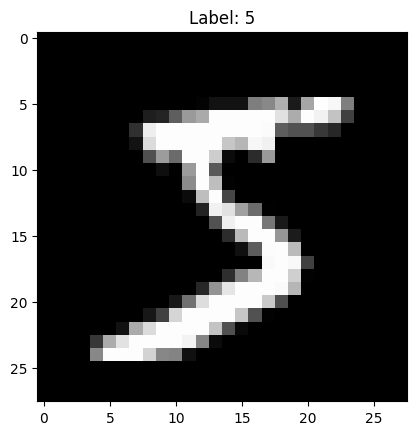

The image size before squeeze: torch.Size([1, 28, 28])
The image size after squeeze: torch.Size([28, 28])


In [3]:
image, label = train_data[0]

plt.imshow(image.squeeze(), cmap='gray')  # .squeeze() removes the dimensions
                                          # if these dimensions = 1
                                          # In this case, the dim = 1 is
                                          # the channel number, which is the
                                          # gray scale
plt.title(f"Label: {label}")
plt.show()
print('The image size before squeeze:', image.shape)
print('The image size after squeeze:', image.squeeze().shape)
del image, label

In [ ]:
#@title Define the CNN model
class CNN_Net(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNN_Net, self).__init__()
        self.num_classes = num_classes
        self.input_shape = input_shape

        self.CNNLayer = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(16, 3, 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            )

        self.flattened_size = self.get_flattened_size()

        self.FullyConnected = nn.Sequential(
            nn.Linear(self.flattened_size, 120),
            nn.Sigmoid(),
            nn.Linear(120, 60),
            nn.Sigmoid(),
            nn.Linear(60, self.num_classes)
            )

    def get_flattened_size(self):
        # Dummy input to calculate flattened size
        with torch.no_grad():
            x = torch.zeros(self.input_shape)
            x = self.CNNLayer(x)
            return x.view(1, -1).size(1)

    def forward(self,x):
        x = self.CNNLayer(x)
        x = x.view(x.size(0), -1)
        x = self.FullyConnected(x)
        return x

# model = CNN_Net(input_shape = (1, 1, 28, 28),
#                 num_classes = 10).to(device)
# test = model(image.unsqueeze(0).to(device))

In [ ]:
#@title Training steps
def Training(train_data, batch_size, num_epochs, lr, device = 'cpu'):
    # Create training and testing batch
    train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                            batch_size = batch_size,
                                            shuffle = True)

    model = CNN_Net(input_shape = (1, 1, 28, 28),
                    num_classes = 10).to(device)
    Loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)


    for epoch in range(num_epochs):
        for i ,(image, label) in enumerate(train_gen):
            image = image.to(device)
            label = label.to(device)

            optimizer.zero_grad()

            y_hat = model(image)

            loss = Loss(y_hat, label)
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'%
                      (epoch+1, num_epochs,
                       i+1, len(train_data)//batch_size,
                       loss.item()))
        del i
    del epoch
    print('Finished Training')
    return model

model = Training(train_data, batch_size = 200, num_epochs = 10, lr = 1e-1,
                 device = device)
torch.save(model.state_dict(), 'cnn.pth')

In [ ]:
#@title testing steps
def testing(model, test_data, batch_size, device = 'cpu'):
    test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                        batch_size = batch_size,
                                        shuffle = True)
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]

    for images, labels in test_gen:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
        del i

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')
    return acc, images, labels

with torch.no_grad():
    acc, images, labels = testing(model, test_data, batch_size = 200,
                                  device = device)


# Prediction for denmonstration

In [4]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from google.colab import files

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                        batch_size = 10000,
                                        shuffle = True)
for images, labels in test_gen:
    print(images.shape)
    print(labels.shape)



torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [5]:
#@title Define the CNN model
class CNN_Net(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNN_Net, self).__init__()
        self.num_classes = num_classes
        self.input_shape = input_shape

        self.CNNLayer = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(16, 3, 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            )

        self.flattened_size = self.get_flattened_size()

        self.FullyConnected = nn.Sequential(
            nn.Linear(self.flattened_size, 120),
            nn.Sigmoid(),
            nn.Linear(120, 60),
            nn.Sigmoid(),
            nn.Linear(60, self.num_classes)
            )

    def get_flattened_size(self):
        # Dummy input to calculate flattened size
        with torch.no_grad():
            x = torch.zeros(self.input_shape)
            x = self.CNNLayer(x)
            return x.view(1, -1).size(1)

    def forward(self,x):
        x = self.CNNLayer(x)
        x = x.view(x.size(0), -1)
        x = self.FullyConnected(x)
        return x

In [6]:
def pred_simple(i, device):
    image = images[i, :, :, :]
    label = labels[i]

    # Move image and label to CPU for display and avoid GPU-related issues
    image_cpu = image.cpu()
    label_cpu = label.cpu()

    plt.imshow(image_cpu.squeeze(), cmap='gray')
    plt.title(f"Label: {label_cpu.item()}")
    plt.show()

    # Check if cnn.pth exists; if not, prompt user to upload it
    if not os.path.exists('cnn.pth'):
        print("File 'cnn.pth' not found.")
        print("Please upload the pre-trained model file now (cnn.pth).")
        uploaded = files.upload()
        if 'cnn.pth' not in uploaded:
            raise FileNotFoundError("cnn.pth not uploaded. Please upload the file and try again.")

    # Initialize model and load weights
    test = CNN_Net(input_shape=(1, 1, 28, 28), num_classes=10)
    test.load_state_dict(torch.load('cnn.pth', map_location=device))
    test.to(device)
    test.eval()  # Important: set model to evaluation mode

    # Move image to device and perform prediction
    image = image.to(device)
    with torch.no_grad():
        _, pred = torch.max(test(image.unsqueeze(0)), 1)
    # print(pred.cpu().numpy())
    return pred.cpu().numpy(), label.numpy()

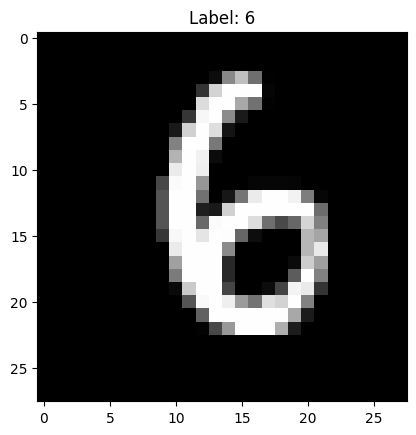

y predicted 6, and the true label is 6


In [15]:
# %%
y_pred, y_true = pred_simple(np.random.randint(low = 0, high = 200), device)
print('y predicted %d, and the true label is %d'%(y_pred[0], y_true))